Pretraining Epoch 100/1000, Loss: 4.216767311096191
Pretraining Epoch 200/1000, Loss: 2.2159383296966553
Pretraining Epoch 300/1000, Loss: 1.5837947130203247
Pretraining Epoch 400/1000, Loss: 0.8023741841316223
Pretraining Epoch 500/1000, Loss: 0.07421047240495682
Pretraining Epoch 600/1000, Loss: 0.0335402637720108
Pretraining Epoch 700/1000, Loss: 0.013603854924440384
Pretraining Epoch 800/1000, Loss: 0.005975556559860706
Pretraining Epoch 900/1000, Loss: 0.0032730416860431433
Pretraining Epoch 1000/1000, Loss: 0.0022771572694182396


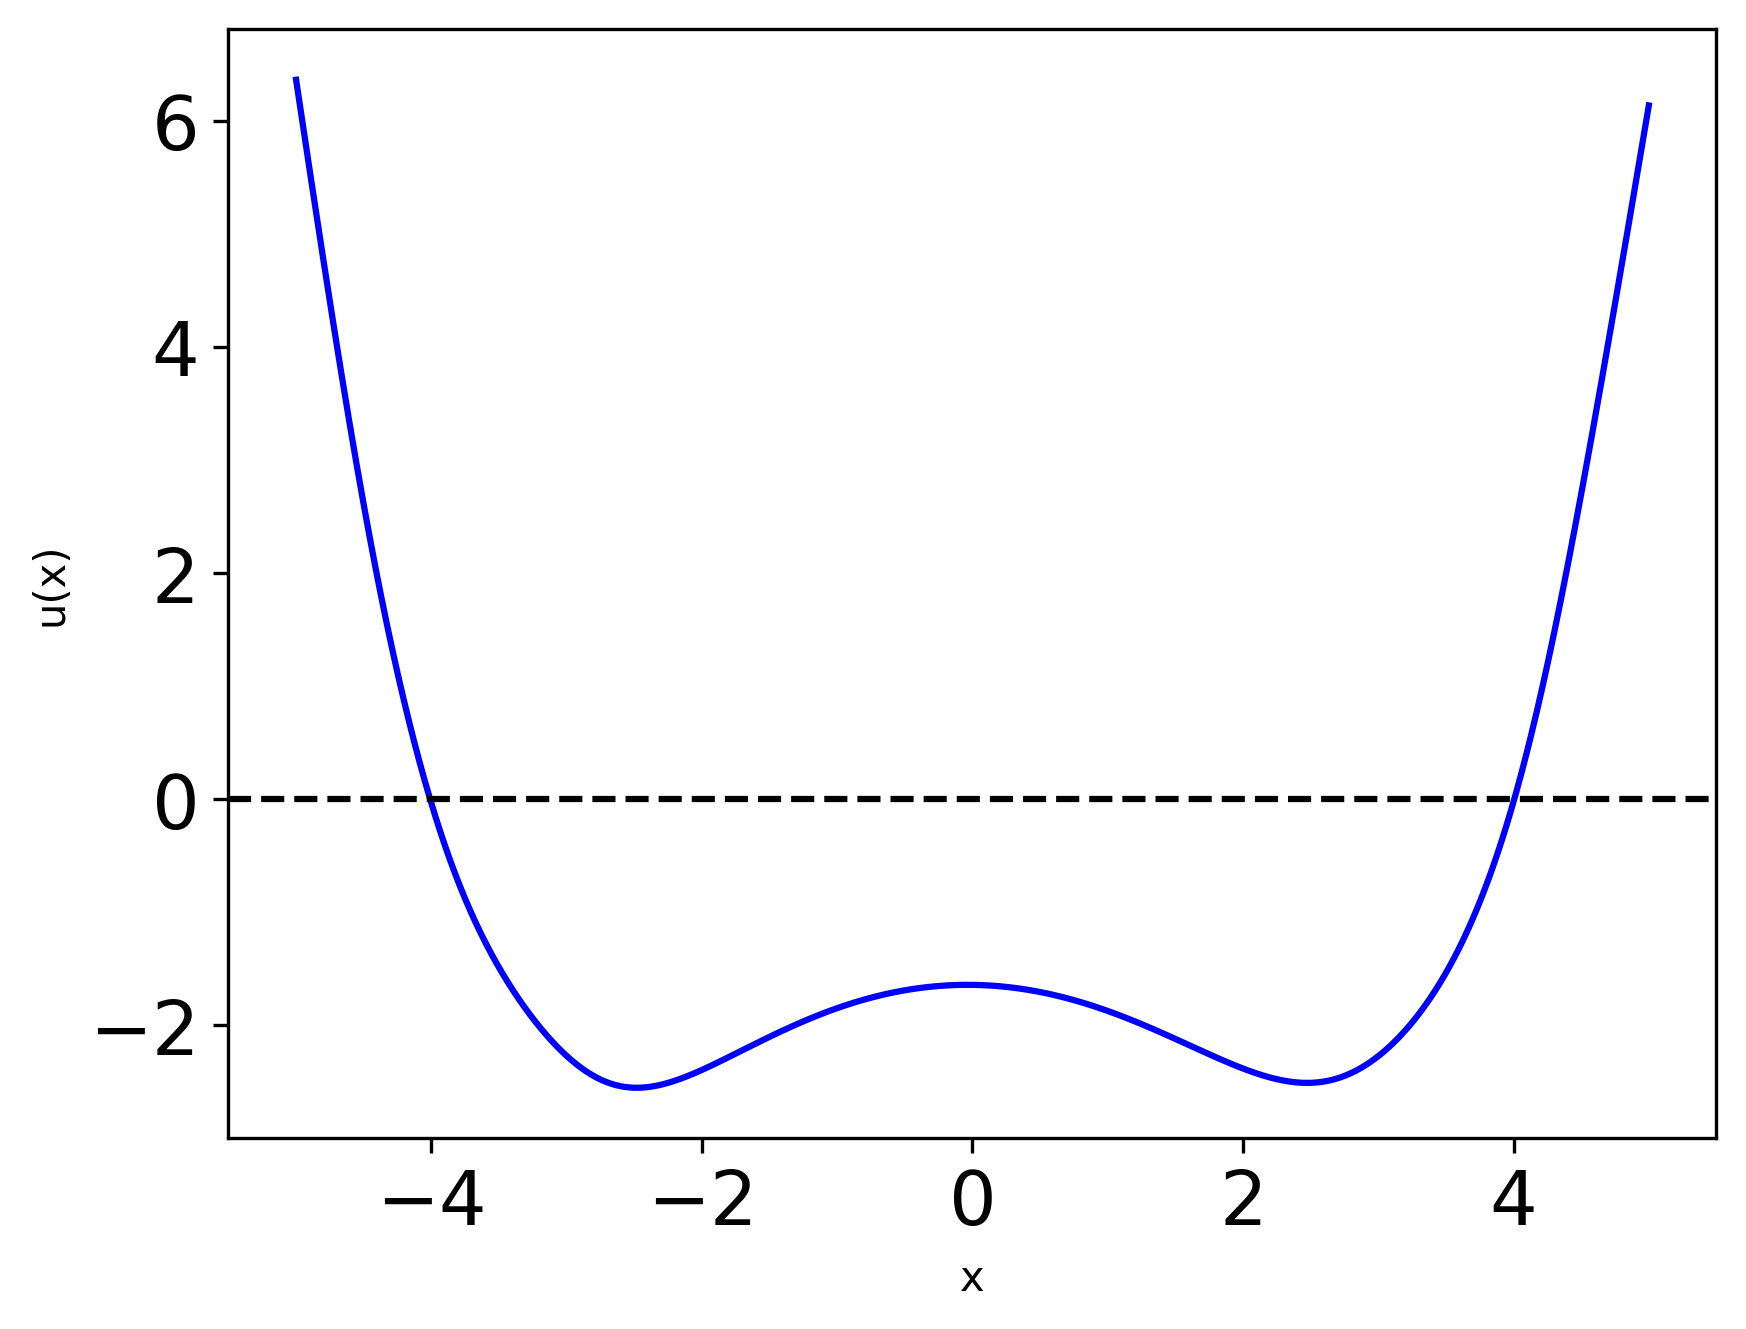

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import torch.nn.functional as F

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, root=4, range=5, squared_x_coe=0.3, pretrain_lr=0.001, pretrain_epochs=1000, resolution=4000):
        super(SimpleNN, self).__init__()
        # Define 4 fully connected layers
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 1)
        
        self.b = squared_x_coe
        self.c = 0.025 * root**4 - self.b * root**2

        # Store the pretraining parameters
        self.pretrain_lr = pretrain_lr
        self.pretrain_epochs = pretrain_epochs
        self.range = range
        self.resolution = resolution

        # Define the target function as per the initialization parameters
        def target_function(x):
            return 0.025 * x**4 - self.b * x**2 - self.c

        self.target_function = target_function

        # Pretrain the network before final training
        self.pretrain()

    def forward(self, x):
        
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = torch.relu(self.fc3(x))
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = F.softplus(self.fc3(x))

        x = self.fc4(x)
        return x

    def pretrain(self):
        # Generate data for pretraining
        x_train = torch.linspace(-self.range, self.range, self.resolution).view(-1, 1)
        y_train = self.target_function(x_train)

        # Define the loss function and optimizer
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=self.pretrain_lr)

        # Pretraining loop
        for epoch in range(self.pretrain_epochs):
            self.train()
            
            # Forward pass
            y_pred = self(x_train)
            loss = criterion(y_pred, y_train)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Log the pretraining loss every 100 epochs
            if (epoch + 1) % 100 == 0:
                print(f'Pretraining Epoch {epoch+1}/{self.pretrain_epochs}, Loss: {loss.item()}')
                
    def visualize(self, y_pred_color='blue', gt=False):
        x_train = torch.linspace(-self.range, self.range, self.resolution).view(-1, 1)
        # Plot the results
        self.eval()
        with torch.no_grad():
            y_pred = self.forward(x_train)
            
        # Create the plot
        plt.figure(dpi=300)
        plt.tick_params(axis='both', which='major', labelsize=18)
        
        # Add the ground truth function if requested
        # The ground truth is |x| - 4 which should be calculated now
        if gt:
            y_gt = abs(x_train) - 4
            plt.plot(x_train.numpy(), y_gt.numpy(), color='grey', linestyle='--', label='Ground Truth')
        
        plt.plot(x_train.numpy(), y_pred.numpy(), color=y_pred_color)
        # Add a horizontal dashed line at y = 0
        plt.axhline(y=0, color='black', linestyle='--', label='y=0')
        plt.xlabel('x')
        plt.ylabel('u(x)')
            
        
        # Show the plot
        plt.show()
            

# Initialize the model
model = SimpleNN()
model.visualize()
model_init = copy.deepcopy(model)


In [2]:
# Define the loss function and optimizer
def boundary_loss(model, boundary_points):
    u_boundary = model(torch.tensor(boundary_points, dtype=torch.float32).view(-1, 1))
    return u_boundary.pow(2).mean()

def eikonal_loss(model, x_train):
    # Compute the gradients of the model's output with respect to x
    x_train.requires_grad = True
    u_pred = model(x_train)
    # Compute gradients with respect to x
    grad_u = torch.autograd.grad(outputs=u_pred, inputs=x_train, 
                                 grad_outputs=torch.ones_like(u_pred), 
                                 create_graph=True)[0]
    # Enforce |grad u| = 1
    return ((grad_u.norm(2, dim=1) - 1)**2).mean()

def SPE_loss(model, x_train, _lambda = 10):
    # Compute the gradients of the model's output with respect to x
    x_train.requires_grad = True
    u_pred = model(x_train)
    transformed_u  = torch.exp(-_lambda * u_pred.abs())
    # Compute gradients with respect to x
    grad_u = torch.autograd.grad(outputs=u_pred, inputs=x_train, 
                                 grad_outputs=torch.ones_like(u_pred), 
                                 create_graph=True)[0]
    spe_loss = transformed_u**2 * (grad_u**2 + 1)
    # Compute the loss
    return spe_loss.mean()

def div_loss(model, x_train):
    # Compute the gradients of the model's output with respect to x
    x_train.requires_grad = True
    u_pred = model(x_train)
    # Compute gradients with respect to x
    u_x = torch.autograd.grad(outputs=u_pred, inputs=x_train, 
                                 grad_outputs=torch.ones_like(u_pred), 
                                 create_graph=True,
                                 retain_graph=True)[0]
    
    
    u_xx = torch.autograd.grad(outputs=u_x, inputs=x_train,
                                 grad_outputs=torch.ones_like(u_x),
                                 create_graph=True,
                                 retain_graph=True)[0]

    
    # Compute the loss
    return u_xx.mean()

def directional_div_loss(model, x_train):
    # Compute the gradients of the model's output with respect to x
    x_train.requires_grad = True
    u_pred = model(x_train)
    # Compute gradients with respect to x
    u_x = torch.autograd.grad(outputs=u_pred, inputs=x_train, 
                                 grad_outputs=torch.ones_like(u_pred), 
                                 create_graph=True)[0]
    
    u_xx = torch.autograd.grad(outputs=u_x, inputs=u_pred,
                                 grad_outputs=torch.ones_like(u_x),
                                 create_graph=True)[0]
    
    # Compute the loss
    return (u_x**2 * u_xx).mean()

Epoch 1/50000, Total Loss: 0.6492131948471069, Boundary Loss: 0.000808407086879015, Eikonal Loss: 6.4840474128723145


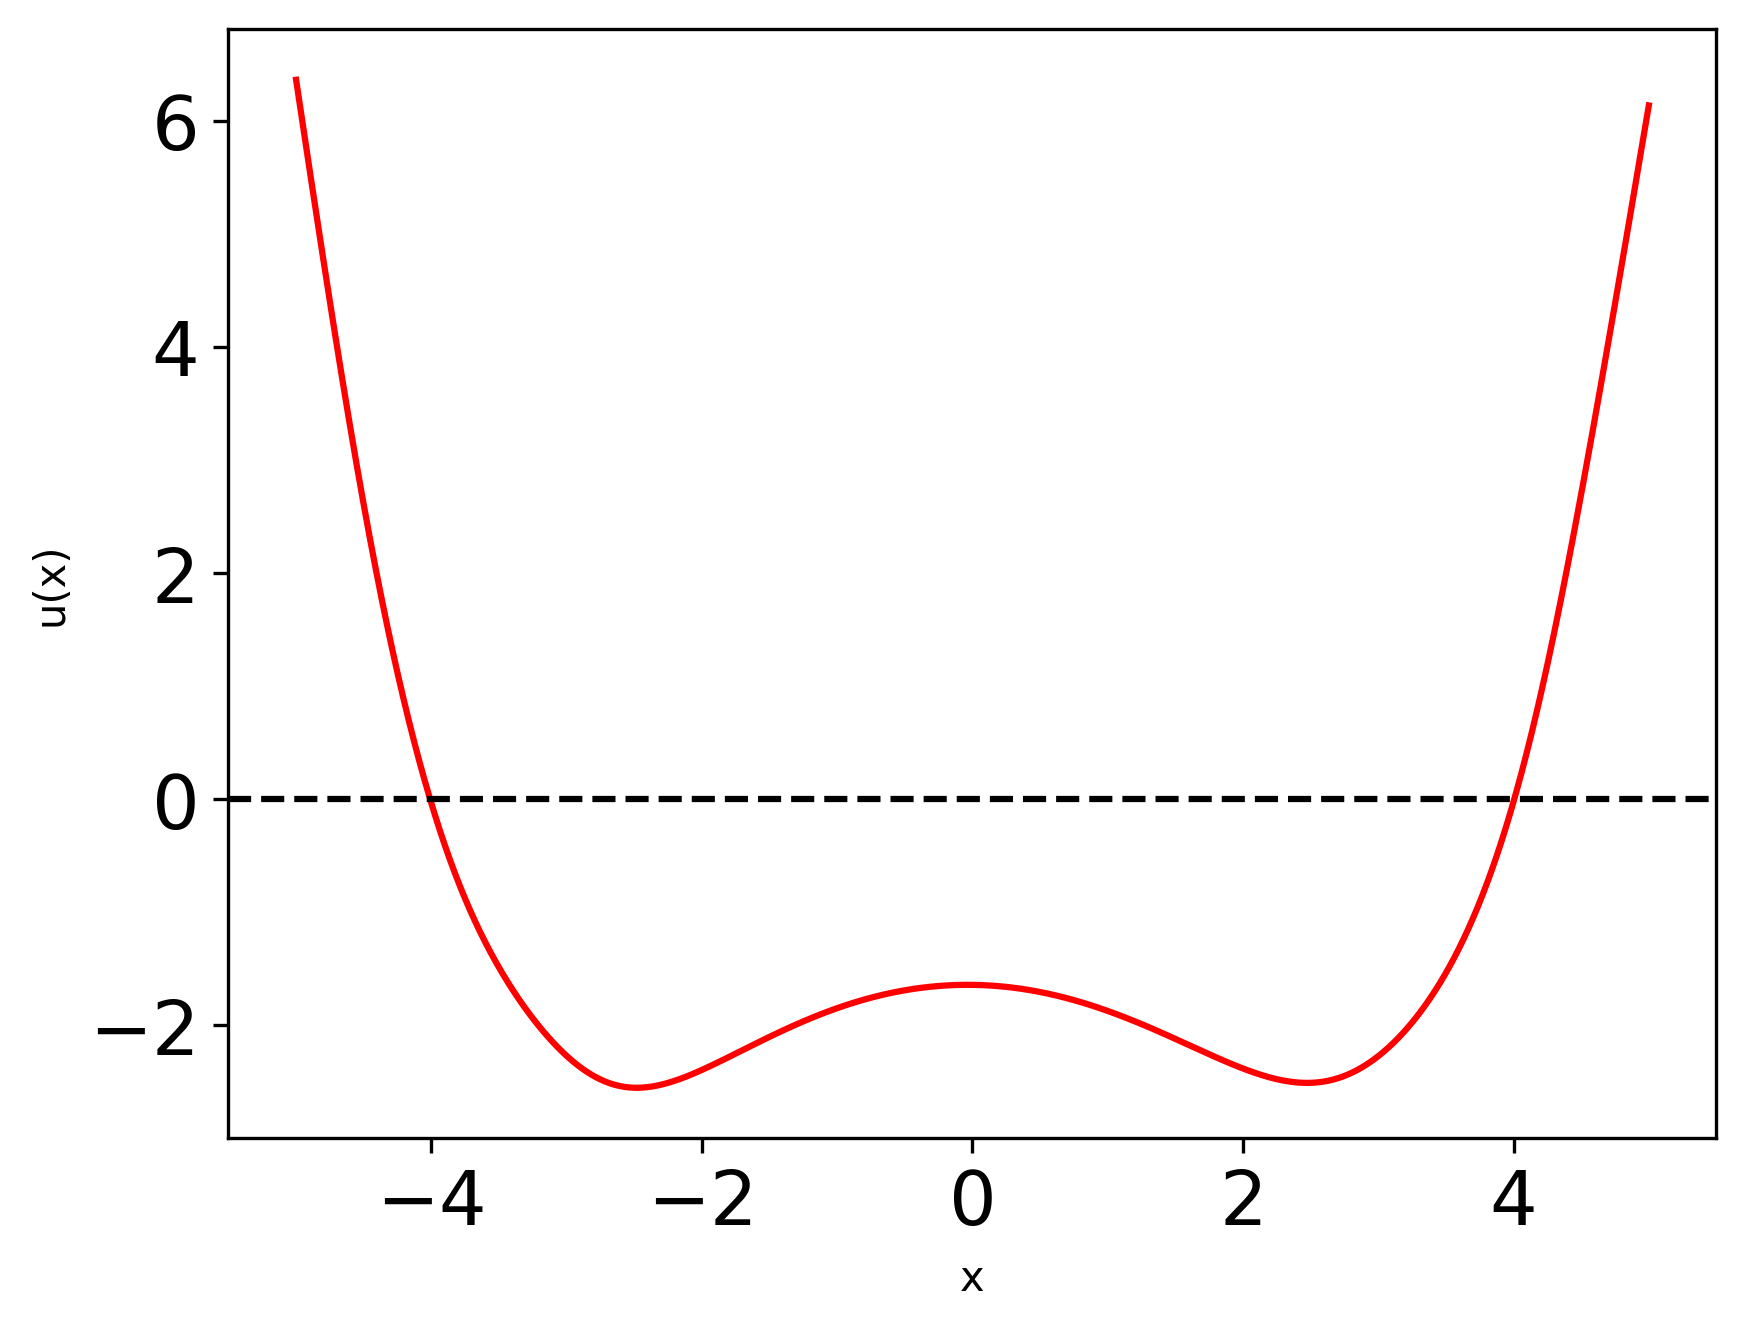

KeyboardInterrupt: 

In [4]:
# Boundary loss + Eikonal loss
eikonal_model = copy.deepcopy(model_init)
optimizer = optim.Adam(eikonal_model.parameters(), lr=0.0025)
x_train = torch.rand(eikonal_model.resolution*8).view(-1, 1) * (2 * eikonal_model.range) - eikonal_model.range

# Training loop
epochs = 50000
boundary_points = [4, -4]  # Enforcing u(4) = 0 and u(-4) = 0
for epoch in range(epochs):
    eikonal_model.train()
    
    # Compute model predictions
    y_pred = eikonal_model(x_train)
    
    # Boundary loss (push u(4) = 0 and u(-4) = 0)
    L_boundary = boundary_loss(eikonal_model, boundary_points)
    
    # Eikonal loss (push |grad u(x)| = 1)
    L_eikonal = eikonal_loss(eikonal_model, x_train)
    
    # Total loss: boundary loss + eikonal loss
    # For relu
    total_loss = L_boundary + 0.1*L_eikonal

    if epoch % 2500 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Total Loss: {total_loss.item()}, Boundary Loss: {L_boundary.item()}, Eikonal Loss: {L_eikonal.item()}')
        eikonal_model.visualize(y_pred_color='red')
    
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
# Visualize the final image
eikonal_model.visualize(y_pred_color='red', gt=True)

    
    


Epoch 1/200000, Total Loss: 7.319921493530273, Boundary Loss: 0.000808407086879015, SPE Loss: 0.3581160306930542


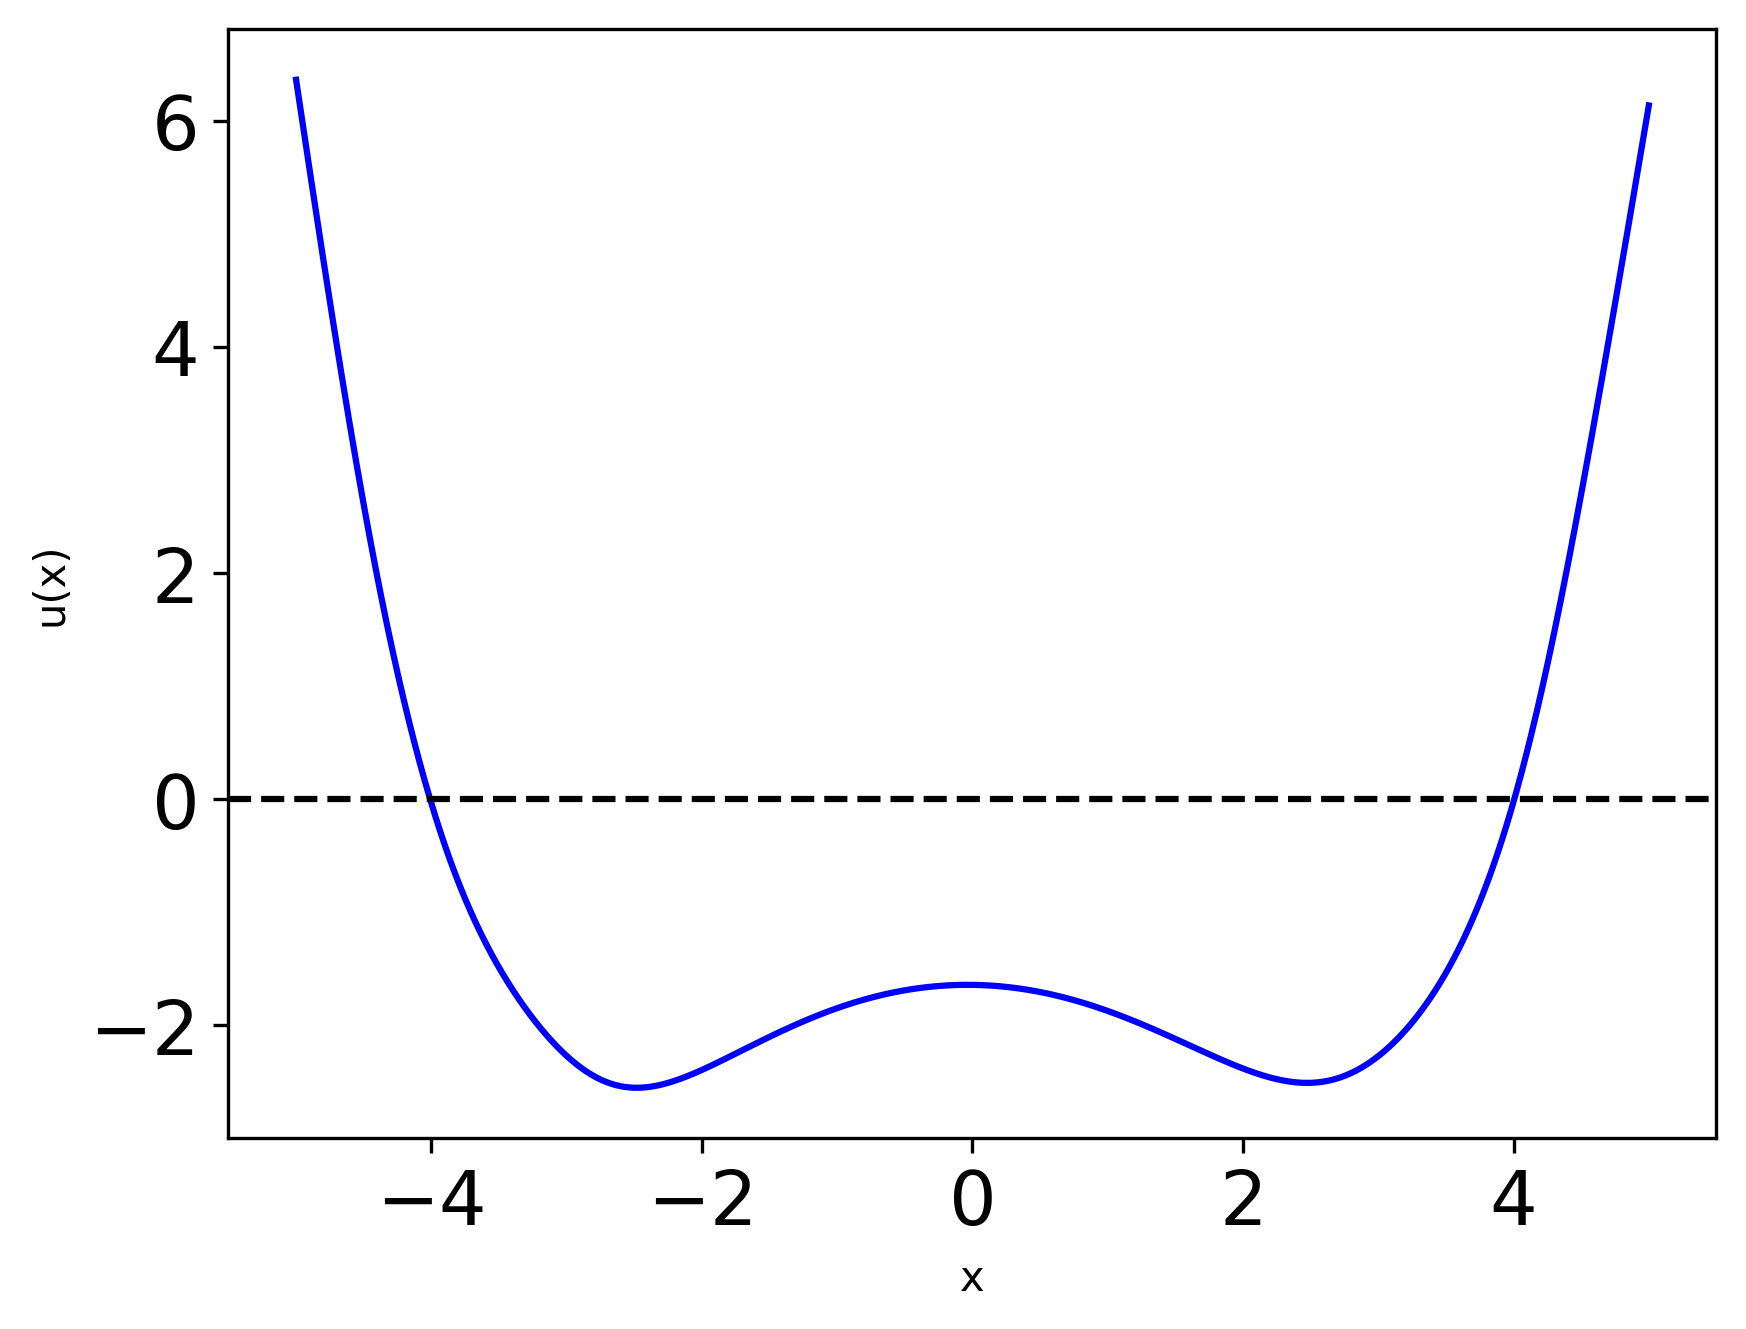

KeyboardInterrupt: 

In [7]:
# Boundary loss + SPE loss
spin_model = copy.deepcopy(model_init)
optimizer = optim.Adam(spin_model.parameters(), lr=0.0025)
x_train = (
    torch.rand(spin_model.resolution * 8).view(-1, 1) * (2 * spin_model.range) - spin_model.range
)
# x_train = torch.linspace(-spin_model.range, spin_model.range, spin_model.resolution).view(-1, 1)

# Training loop
epochs = 200000
boundary_points = [4, -4]  # Enforcing u(4) = 0 and u(-4) = 0
for epoch in range(epochs):
    spin_model.train()

    # Compute model predictions
    y_pred = spin_model(x_train)

    # Boundary loss (push u(4) = 0 and u(-4) = 0)
    L_boundary = boundary_loss(spin_model, boundary_points)

    # Eikonal loss (push |grad u(x)| = 1)
    L_spe = SPE_loss(spin_model, x_train, _lambda=2.5)

    L_eik = eikonal_loss(spin_model, x_train)

    # Total loss: boundary loss + eikonal loss
    total_loss = L_boundary + 2 * L_spe + 1 * L_eik

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss.item()}, Boundary Loss: {L_boundary.item()}, SPE Loss: {L_spe.item()}"
        )
        spin_model.visualize("blue")

    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

# Visualize the final image
spin_model.visualize("blue", gt=True)